In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [3]:
pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg

# San Diego Region Crime Incidents 2007 - 2013
`sandag.gov-crime-2007e2013-2.1.2` Last Update: 2020-11-24T04:23:58

_Processed crime incidents for San Diego county, 2007-2013. Of our crime datasets, this one is most useful for analysis._

Processed crime incidents, based on data supplied by SANDAG.

Important:

  * See Caveats for limitations and warnings regarding this data. 
  * Use of this data is subject to multiple terms and conditions. See Terms for details. 

This dataset includes geocoded crime incidents from 1 Jan 2007 to 31 March 2013 that were returned by SANDAG for Public Records request 12-075. 


Asr\_zone Codes
===============

The integer values in the asr\_zone field are taken directly from the [SANGIS parcel data](http://rdw.sandag.org/file_store/Parcel/Parcels.pdf). These values are: 

	╔════╦═════════════════════════════════╗
	║ -1 ║ Unset                           ║
	║  0 ║ Unzoned                         ║
	║  1 ║ Single family residential (R-1) ║
	║  2 ║ Minor multiple (R-2)            ║
	║  3 ║ Restricted multiple (R-3)       ║
	║  4 ║ Multiple residential (R-4)      ║
	║  5 ║ Restricted commercial           ║
	║  6 ║ Commercial                      ║
	║  7 ║ Industrial (M zone)             ║
	║  8 ║ Agricultural                    ║
	║  9 ║ Special and/or misc.            ║
	╚════╩═════════════════════════════════╝				



Addresses and Geocoding
=======================
SANDAG returns the position of incidents as a block address, and occasionally as an intersection. Block addresses are the original address of the incident, with the last two digits set to '00'. 

Before geocoding, all of the original block addresses are normalized to be more consistent and to remove different versions of the same address. There are a few transformations performed on the address, including:

  * Converting street types synonyms like 'Avenue', 'Avenu' and 'ave.' to standard abbreviations like 'ave.'
  * Converting street directions ( 'West main Street' ) to abbreviations like 'W Main st'

Many geocoders are designed to work with mailable addresses, and block addresses are not real postal addresses. This data is geocoded with custom code that uses the SANGIS streets database, matching the block addresses to a street segment. This produces more sensible results, because the crime is attributed to an entire block, rather than to an arbitrary point on the block. However, with the crime is represented as a point, it will appear at the location of the center of the street segment, usually in the middle of the block. 

This means that all of the incidents on a block will appear at a single location. In most GIS programs, it is difficult to see that there are actually many points in one place. Be aware that each point you see may actually be dozens of incidents. 

The files that SANDAG returned included 1,008,524 incident records, and 953,824 records were geocoded (95%). The 'gctype' field has a value of NONE when the  record was not geocoded, and any field that depends on a locations, such as x, y, lon, lat, segment_id, community, and others, will have default values. 

Caveats
=======

As with most crime data, there are many issues, limitations and problems that users must be aware of to avoid making incorrect conclusions. 

*Crime incident data is inherently problematic.* Crime incident reports are collected by busy officers in stressful situations who are trying to describe complex situations with rigid categories. Virtually every point of the data collection process has multiple opportunities for errors and few opportunities for correction after the fact. Analysts must consider the difficulties of collecting crime data when assessing the validity of any conclusions. 

*Data is collected by 19 different agencies.* While the data is all sourced from SANDAG, it originates with 19 different police departments. These departments may have different policies that can result in different categorizations for the same crime, and they m

In [4]:
import rowgenerators as rg
i5y = rg.dataframe('https://s3.amazonaws.com/s3.sandiegodata.org/repo/clarinova.com/crime-incidents-casnd-7ba4-r3/incidents-5y.csv')
i5y['datetime'] = pd.to_datetime(i5y['date']+' '+i5y['time'])

In [5]:
incidents = pkg.resource('incidents').geoframe()

incidents['doy'] = incidents.datetime.dt.dayofyear
incidents['dummy'] = 1
# Make Day of week a categorical with proper names, and ordered, so it will sort correctly. 
dow = ['M','T','W','Th','F','Sa','Su']
incidents['dow'] = pd.Categorical(incidents.dow.replace(dict(zip(range(len(dow)),dow))), categories=dow, ordered=True)


In [19]:

def prep_fft(df, freq='H'):
    y = df.set_index('datetime').groupby(pd.Grouper(freq=freq)).count()['desc'].astype(int)
    x = y.reset_index().index.values
    
    return y


def fft(s, N=None, T=1):

    import scipy.fftpack
    
    if N is None:
        N = len(s)
    
    yf = scipy.fftpack.fft(s)[:N//2]
    xf = np.linspace(0.0, 1.0/(2.0*T),N//2)
    amp = 2.0/N * np.abs(yf)
    
    df =   pd.DataFrame({'freq':xf, 'amp':amp})
    df['period'] = df.freq.rtruediv(1.0).replace([np.inf, -np.inf], np.nan)
    
    return df

def plot_fft(f, freq_title='hours', brk=60, limit=180):
    fig, ax = plt.subplots(2,1, figsize=(20, 6))
    ax = ax.flat

    ax[0].set_xlim(0,brk)
    ax[0].plot(f.period, f.amp, marker='x')
    ax[0].set_title(f'Amplitudes, 0 to {brk} {freq_title}', fontsize=18)

    ax[1].set_xlim(brk,limit)
    ax[1].plot(f.period, f.amp, marker='x' )
    ax[1].set_title(f'Amplitudes, {brk} to {limit} {freq_title}', fontsize=18)


    plt.tight_layout()
    plt.show()

    display(f[f.period<180].dropna().set_index('period').sort_values('amp',ascending=False).head(20))
    


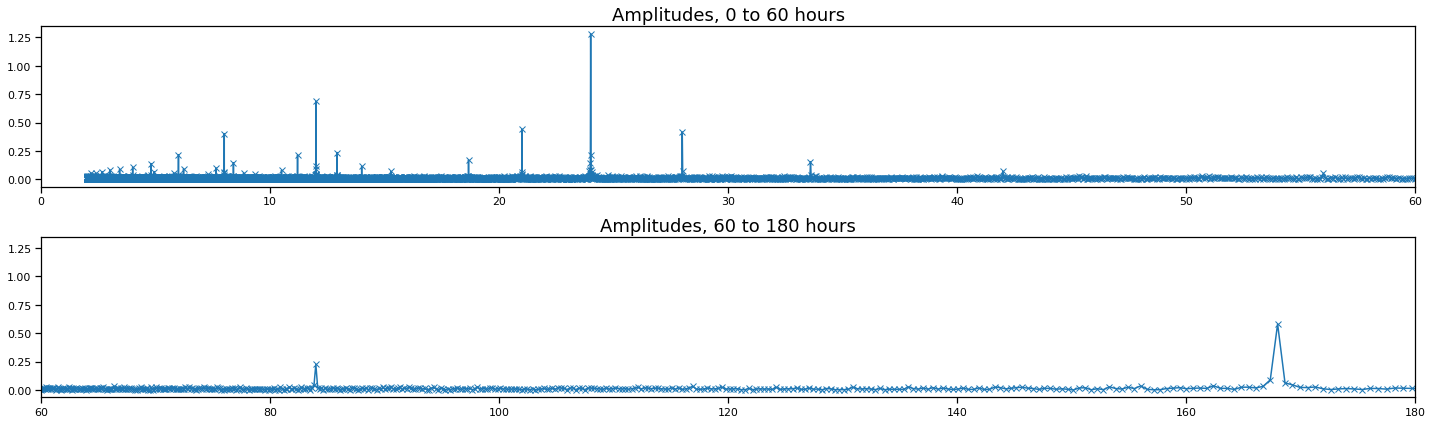

,freq,amp
period,,
23.998905,0.041669,1.283195
11.999453,0.083337,0.690144
167.992337,0.005953,0.581463
20.999042,0.047621,0.443698
27.998723,0.035716,0.417982
7.999635,0.125006,0.403144
12.922487,0.077384,0.236943
83.996169,0.011905,0.225871
5.999726,0.166674,0.216736


In [17]:

t = incidents[(incidents.category=='DUI') & (incidents.datetime.dt.year >=2008) & (incidents.datetime.dt.year <2013)].copy()
y1 = prep_fft(t, 'H')
f = fft(y1)
plot_fft(f)


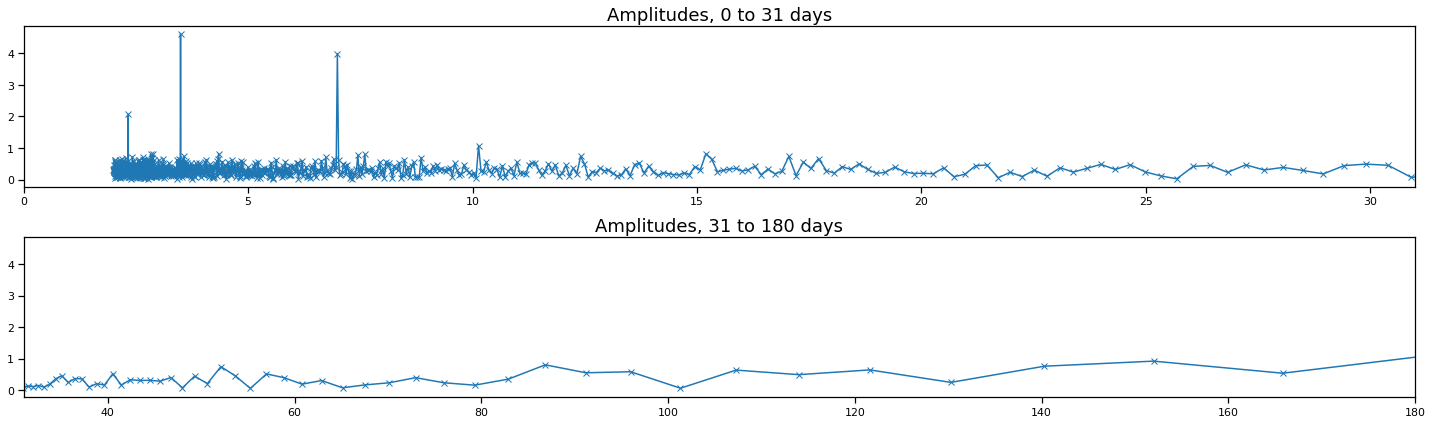

,freq,amp
period,,
3.494253,0.286184,4.624044
6.988506,0.143092,3.985488
2.329502,0.429276,2.069901
10.133333,0.098684,1.072610
152.000000,0.006579,0.921353
4.342857,0.230263,0.825607
15.200000,0.065789,0.822285
2.827907,0.353618,0.808660
86.857143,0.011513,0.803639


In [25]:
t = incidents[(incidents.category=='BURGLARY') & (incidents.datetime.dt.year >=2008) & (incidents.datetime.dt.year <2013)].copy()
y1 = prep_fft(t, 'D')
f = fft(y1)
plot_fft(f, freq_title='days', brk=31)